+++ 
date = "2018-12-27"
title = "Classical Speech Enhancement Techniques"
markup = "mmark"
+++

# Classical Speech Enhancement Part 1: Spectral subtraction

This is part 1 in a series of three posts that re-implement in Python three classical DSP methods of enhancing speech in audio recordings. It uses slides and code from a source separation tutorial that can be found [here](https://ccrma.stanford.edu/~njb/teaching/sstutorial/). The three methods are spectral subtraction, Wiener filtering and probabilistic estimation (Ephraim-Malah). 

## The general framework

The speech enhancement problem is posed as a source separation problem -- given a mixture of noise ($d[n]$) and signal ($x[n]$), separate the two. We model the given audio in the frequency space as: $Y(\omega) = X(\omega) + D(\omega)$

To convert the original audio sequence $y[n]$ into $Y(\omega)$, we first convert it into a sequence of overlapping frames. Each frame indexed by $m$ has $M$ samples and an overlap determined by $R$ eg. if $R = M/2$, we have 50% overlap. We take each frame's fourier transform (FFT) to get $Y_{m}(\omega)$. Then our goal is to estimate $X_{m}(\omega)$ as $\hat{X}_{m}(\omega)$. We can reconstruct the desired audio $\hat{x}(\omega)$ using  an inverse FFT and overlap-add.

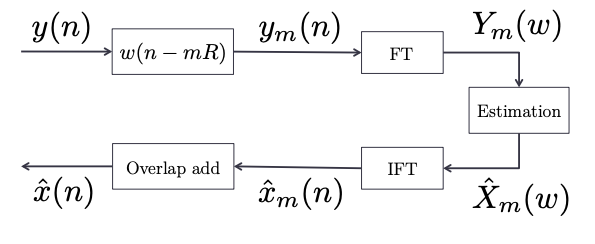

The challenge is to model our noise $D(\omega)$ and estimate $X(\omega)$. One approach to modeling the noise is by making the assumption that noise is slowly varying compared to speech. Using a voice activity detector, we can tell what frames do not have speech, and estimate $D(\omega)$ from those frames (eg. by averaging).

The general algorithm for producing the magnitude of the signal estimate $|\hat{X}(\omega)|$ can be reduced to designing a gain curve $H_{m}(\omega) = |\hat{X}_{m}(\omega)|/|Y_{m}(\omega)|$. i.e for each mth audio frame $Y_{m}(\omega)$, we derive the estimate $|\hat{X}_{m}(\omega)|$ by multiplying by a gain curve: $|\hat{X}_{m}(\omega)| = |H_{m}(\omega)| |Y_{m}(\omega)|$. The gain curve $H_{m}(\omega)$ determines the scaling factors (or gains) for each spectral component $\omega$. The three different methods, as we'll see soon, provide different gain curves depending on different assumptions which lead to varying subjective results in speech enhancement.

In [40]:
import numpy as np
import segmentaxis 

def get_frames(y: np.array, m=128, overlap=0.5) -> np.array:
    """Convert y[n] into a matrix of frames Y_m(w)"""
    # Design a hanning window with proper scaling to make the window unit-norm
    win = np.hanning(m)
    win = win / np.sqrt(np.linalg.norm(win))

    # Create output array
    out = segmentaxis.segment_axis(y, m, int(overlap*m), end='pad')
    out = out * win # Apply the window to each row/frame/chunk
    return out

## 1. Spectral subtraction

### a) Magnitude spectral subtraction

Spectral subtraction works by producing an estimate for the magnitude of $D(\omega)$ i.e $|D(\omega)|$ by averaging all the frames that have noise in them. The averaging operation is denoted by the expectation operator $E[D(\omega)]$. Once we estimate the magnitude of the noise, we simply subtract the input signal from the noise estimate to get the signal estimate $\hat{X}(\omega)$. Since the magnitude of $\hat{X}(\omega)$ needs to be non-negative, we rectify the difference using the max operator. The phase of the estimate is retained as the same as the input signal $Y(\omega)$.  

![image.png](img/mag_spectral_subtraction.png)

### b) Power spectral subtraction

The power spectral subtraction is a generalization of magnitude spectral subtraction where we simply take the $\alpha$th power for each of the magnitude terms.

![image.png](img/power_spectral_subtraction.png)

Re-formulating the above formula to put it in the Gain curve setup, we get 

![image.png](img/gain_spectral_subtraction.png)

![image.png](img/gain_curve_spectral_subtraction.png)

How well does power s